# Проект: Аналитика популярного сервиса аренды самокатов GoFast

***Описание проекта***

Вы аналитик популярного сервиса аренды самокатов GoFast. Вам передали данные о некоторых пользователях из нескольких городов, а также об их поездках. Проанализируйте данные и проверьте некоторые гипотезы, которые могут помочь бизнесу вырасти.

Чтобы совершать поездки по городу, пользователи сервиса GoFast пользуются мобильным приложением. Сервисом можно пользоваться:

* без подписки 
* абонентская плата отсутствует;
* стоимость одной минуты поездки — 8 рублей;
* стоимость старта (начала поездки) — 50 рублей;
* с подпиской Ultra 
* абонентская плата — 199 рублей в месяц;
* стоимость одной минуты поездки — 6 рублей;
* стоимость старта — бесплатно.

***Описание данных***

В основных данных есть информация о пользователях, их поездках и подписках.

**Пользователи — users_go.csv**

* user_id — уникальный идентификатор пользователя
* name — имя пользователя
* age — возраст
* city — город
* subscription_type — тип подписки (free, ultra)

**Поeздки — rides_go.csv**

* user_id — уникальный идентификатор пользователя
* distance — расстояние, которое пользователь проехал в текущей сессии (в метрах)
* duration — продолжительность сессии (в минутах) — время с того момента, как пользователь нажал кнопку «Начать поездку» до момента, как он нажал кнопку «Завершить поездку»
* date — дата совершения поездки

**Подписки — subscriptions_go.csv**

* subscription_type — тип подписки
* minute_price — стоимость одной минуты поездки по данной подписке
* start_ride_price — стоимость начала поездки
* subscription_fee — стоимость ежемесячного платежа



#### Шаг 1. Загрузка данных

***Импортируем библиотеки***

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import plotly.express as px
import numpy as np
from scipy import stats as st
from datetime import datetime, timedelta
from math import sqrt
from math import factorial
from scipy.stats import binom, norm
from matplotlib import rcParams, rcParamsDefault

import warnings
warnings.filterwarnings('ignore')

In [2]:
import nbformat as nbf
from glob import glob

import uuid
def get_cell_id(id_length=8):
    return uuid.uuid4().hex[:id_length]

# your notebook name/keyword
nb_name = 'my_notebook'
notebooks = list(filter(lambda x: nb_name in x, glob("./*.ipynb", recursive=True)))

# iterate over notebooks
for ipath in sorted(notebooks):
    # load notebook
    ntbk = nbf.read(ipath, nbf.NO_CONVERT)
    
    cell_ids = []
    for cell in ntbk.cells:
        cell_ids.append(cell['id'])

    # reset cell ids if there are duplicates
    if not len(cell_ids) == len(set(cell_ids)): 
        for cell in ntbk.cells:
            cell['id'] = get_cell_id()

    nbf.write(ntbk, ipath)

***Импортируем данные в датасет***

In [3]:
try:
    users = pd.read_csv('/datasets/users_go.csv')
    riders = pd.read_csv('/datasets/rides_go.csv')
    subs = pd.read_csv('/datasets/subscriptions_go.csv')
except:
    users = pd.read_csv('https://code.s3.yandex.net/datasets/users_go.csv')
    riders = pd.read_csv('https://code.s3.yandex.net/datasets/rides_go.csv')
    subs = pd.read_csv('https://code.s3.yandex.net/datasets/subscriptions_go.csv')

***Проверяем данные***

In [4]:
def inspect(df):
    display(df.head()) 
    df.info() 
    print ('Количество дубликатов -', df.duplicated().sum())
    numeric_columns=df.describe().columns
    display(df.describe())
    display()
    df.columns = [x.lower().replace(' ', '_') for x in df.columns.values]
    for column_name in df.columns:
        if column_name not in numeric_columns:
            if 'session' in column_name or 'dt' in column_name:
                df[column_name] = pd.to_datetime(df[column_name])
            else:
                display(df[column_name].value_counts())
                print(50*'*')
    return df
users = inspect(users)
riders = inspect(riders)
subs = inspect(subs)

,user_id,name,age,city,subscription_type
0,1,Кира,22,Тюмень,ultra
1,2,Станислав,31,Омск,ultra
2,3,Алексей,20,Москва,ultra
3,4,Константин,26,Ростов-на-Дону,ultra
4,5,Адель,28,Омск,ultra


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1565 entries, 0 to 1564
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   user_id            1565 non-null   int64 
 1   name               1565 non-null   object
 2   age                1565 non-null   int64 
 3   city               1565 non-null   object
 4   subscription_type  1565 non-null   object
dtypes: int64(2), object(3)
memory usage: 61.3+ KB
Количество дубликатов - 31


,user_id,age
count,1565.000000,1565.000000
mean,762.633866,24.922045
std,443.260155,4.553496
min,1.000000,12.000000
25%,378.000000,22.000000
50%,762.000000,25.000000
75%,1146.000000,28.000000
max,1534.000000,43.000000


Мария        23
Анна         22
Александр    18
Никита       17
Дмитрий      17
             ..
Матвей        3
Семен         2
Радмир        1
Тихон         1
Милана        1
Name: name, Length: 194, dtype: int64

**************************************************


Пятигорск         226
Екатеринбург      206
Ростов-на-Дону    202
Краснодар         196
Сочи              192
Омск              186
Тюмень            185
Москва            172
Name: city, dtype: int64

**************************************************


free     846
ultra    719
Name: subscription_type, dtype: int64

**************************************************


,user_id,distance,duration,date
0,1,4409.919140,25.599769,2021-01-01
1,1,2617.592153,15.816871,2021-01-18
2,1,754.159807,6.232113,2021-04-20
3,1,2694.783254,18.511000,2021-08-11
4,1,4028.687306,26.265803,2021-08-28


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18068 entries, 0 to 18067
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   user_id   18068 non-null  int64  
 1   distance  18068 non-null  float64
 2   duration  18068 non-null  float64
 3   date      18068 non-null  object 
dtypes: float64(2), int64(1), object(1)
memory usage: 564.8+ KB
Количество дубликатов - 0


,user_id,distance,duration
count,18068.000000,18068.000000,18068.000000
mean,842.869936,3070.659976,17.805011
std,434.734317,1116.831209,6.091051
min,1.000000,0.855683,0.500000
25%,487.000000,2543.226360,13.597563
50%,889.000000,3133.609994,17.678395
75%,1213.250000,3776.222735,21.724800
max,1534.000000,7211.007745,40.823963


2021-12-22    72
2021-01-12    70
2021-12-27    69
2021-06-09    67
2021-08-20    67
              ..
2021-07-30    35
2021-11-07    35
2021-02-02    34
2021-12-15    34
2021-07-03    31
Name: date, Length: 364, dtype: int64

**************************************************


,subscription_type,minute_price,start_ride_price,subscription_fee
0,free,8,50,0
1,ultra,6,0,199


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   subscription_type  2 non-null      object
 1   minute_price       2 non-null      int64 
 2   start_ride_price   2 non-null      int64 
 3   subscription_fee   2 non-null      int64 
dtypes: int64(3), object(1)
memory usage: 192.0+ bytes
Количество дубликатов - 0


,minute_price,start_ride_price,subscription_fee
count,2.000000,2.000000,2.000000
mean,7.000000,25.000000,99.500000
std,1.414214,35.355339,140.714249
min,6.000000,0.000000,0.000000
25%,6.500000,12.500000,49.750000
50%,7.000000,25.000000,99.500000
75%,7.500000,37.500000,149.250000
max,8.000000,50.000000,199.000000


ultra    1
free     1
Name: subscription_type, dtype: int64

**************************************************


В датафрейме *users есть 31 дубликат. Если их удалить, то в целом, эти строки не повлияют на результаты дальнейшего анализа данных. В остальном, дубликатов больше нигде не обнаружено. Колонка date* в датафрейме *riders* имеет тип object. Нужно будет изменить тип данных на datetime.

***Для наглядности построим гистограммы по данным users***

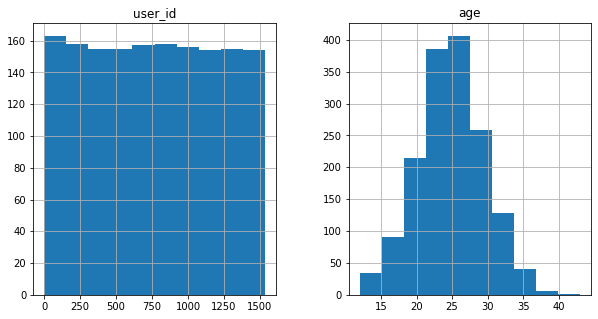

In [5]:
users.hist(figsize=(10, 5));

***Для наглядности построим гистограммы по данным riders***

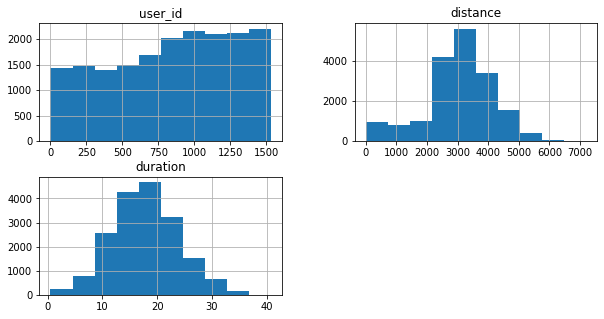

In [6]:
riders.hist(figsize=(10, 5));

В датафрейме users присутствует 5 столбцов, он состоит и 1565 строк. Вес 61.3+KB. Пропуски отсутствуют. Имеются дубликаты в количестве 31, которые будут удалены.
    
В датафрейме riders присутствует 4 столбца, он состоит из 18068 строк. Вес 564.8+KB. Дубликатов не обнаружено, пропусков нет.
    
В датафрейме subs присутствует 4 столбца, он состоит из 2 строк. Вес 192.0+bytes. Дубликатов не обнаружено, пропусков нет.

Названия столбцов соответствуют 'змеиному' стилю - тут все в порядке и в корректировке не нуждаются.

#### Шаг 2. Предобработка данных

***Изменим настройки отображения***

In [7]:
pd.options.display.float_format = '{:,.2f}'.format

***Приведём формат даты и времени к удобному виду***

In [8]:
riders['date'] = pd.to_datetime(riders['date'])
riders['month']= pd.to_datetime(riders['date']).dt.strftime('%Y-%m')
riders['year'] = pd.to_datetime(riders['date']).dt.strftime('%Y')

***Проверим, за какой период предоставлены данные***

In [9]:
riders['date'].dt.year.unique()

array([2021])

Данные предоставлены только за 2021 год.

***Удаляем дубликаты из датафрейма users, столбец user_id***

In [10]:
users.drop_duplicates(inplace=True)

In [11]:
users.duplicated().sum()

0

***Проверим снова, как изменились данные***

In [12]:
def inspect(df):
    display(df.head()) 
    df.info() 
    print ('Количество дубликатов -', df.duplicated().sum())
    numeric_columns=df.describe().columns
    display(df.describe())
    display()
    df.columns = [x.lower().replace(' ', '_') for x in df.columns.values]
    for column_name in df.columns:
        if column_name not in numeric_columns:
            if 'session' in column_name or 'dt' in column_name:
                df[column_name] = pd.to_datetime(df[column_name])
            else:
                display(df[column_name].value_counts())
                print(50*'*')
    return df
users = inspect(users)
riders = inspect(riders)
subs = inspect(subs)

,user_id,name,age,city,subscription_type
0,1,Кира,22,Тюмень,ultra
1,2,Станислав,31,Омск,ultra
2,3,Алексей,20,Москва,ultra
3,4,Константин,26,Ростов-на-Дону,ultra
4,5,Адель,28,Омск,ultra


<class 'pandas.core.frame.DataFrame'>
Int64Index: 1534 entries, 0 to 1533
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   user_id            1534 non-null   int64 
 1   name               1534 non-null   object
 2   age                1534 non-null   int64 
 3   city               1534 non-null   object
 4   subscription_type  1534 non-null   object
dtypes: int64(2), object(3)
memory usage: 71.9+ KB
Количество дубликатов - 0


,user_id,age
count,"1,534.00","1,534.00"
mean,767.50,24.90
std,442.97,4.57
min,1.00,12.00
25%,384.25,22.00
50%,767.50,25.00
75%,"1,150.75",28.00
max,"1,534.00",43.00


Анна         22
Мария        22
Дмитрий      17
Александр    17
Никита       16
             ..
Матвей        3
Семен         2
Радмир        1
Тихон         1
Милана        1
Name: name, Length: 194, dtype: int64

**************************************************


Пятигорск         219
Екатеринбург      204
Ростов-на-Дону    198
Краснодар         193
Сочи              189
Омск              183
Тюмень            180
Москва            168
Name: city, dtype: int64

**************************************************


free     835
ultra    699
Name: subscription_type, dtype: int64

**************************************************


,user_id,distance,duration,date,month,year
0,1,"4,409.92",25.60,2021-01-01,2021-01,2021
1,1,"2,617.59",15.82,2021-01-18,2021-01,2021
2,1,754.16,6.23,2021-04-20,2021-04,2021
3,1,"2,694.78",18.51,2021-08-11,2021-08,2021
4,1,"4,028.69",26.27,2021-08-28,2021-08,2021


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18068 entries, 0 to 18067
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   user_id   18068 non-null  int64         
 1   distance  18068 non-null  float64       
 2   duration  18068 non-null  float64       
 3   date      18068 non-null  datetime64[ns]
 4   month     18068 non-null  object        
 5   year      18068 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(2)
memory usage: 847.1+ KB
Количество дубликатов - 0


,user_id,distance,duration
count,"18,068.00","18,068.00","18,068.00"
mean,842.87,"3,070.66",17.81
std,434.73,"1,116.83",6.09
min,1.00,0.86,0.50
25%,487.00,"2,543.23",13.60
50%,889.00,"3,133.61",17.68
75%,"1,213.25","3,776.22",21.72
max,"1,534.00","7,211.01",40.82


2021-12-22    72
2021-01-12    70
2021-12-27    69
2021-08-20    67
2021-06-09    67
              ..
2021-11-07    35
2021-07-30    35
2021-12-15    34
2021-02-02    34
2021-07-03    31
Name: date, Length: 364, dtype: int64

**************************************************


2021-01    1585
2021-05    1560
2021-06    1553
2021-03    1544
2021-07    1529
2021-12    1527
2021-08    1518
2021-09    1517
2021-04    1506
2021-10    1475
2021-11    1418
2021-02    1336
Name: month, dtype: int64

**************************************************


2021    18068
Name: year, dtype: int64

**************************************************


,subscription_type,minute_price,start_ride_price,subscription_fee
0,free,8,50,0
1,ultra,6,0,199


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   subscription_type  2 non-null      object
 1   minute_price       2 non-null      int64 
 2   start_ride_price   2 non-null      int64 
 3   subscription_fee   2 non-null      int64 
dtypes: int64(3), object(1)
memory usage: 192.0+ bytes
Количество дубликатов - 0


,minute_price,start_ride_price,subscription_fee
count,2.00,2.00,2.00
mean,7.00,25.00,99.50
std,1.41,35.36,140.71
min,6.00,0.00,0.00
25%,6.50,12.50,49.75
50%,7.00,25.00,99.50
75%,7.50,37.50,149.25
max,8.00,50.00,199.00


ultra    1
free     1
Name: subscription_type, dtype: int64

**************************************************


***Вывод:***

Пропущенных данных в таблицах нет.

Дубликаты были среди пользователей, сейчас удалены.

Добавили столбец month и year.

#### Шаг 3. Исследовательский анализ данных

***Частота встречаемости городов***

In [13]:
users_by_city = users['city'].value_counts()

In [14]:
users_by_city

Пятигорск         219
Екатеринбург      204
Ростов-на-Дону    198
Краснодар         193
Сочи              189
Омск              183
Тюмень            180
Москва            168
Name: city, dtype: int64

Лидером является Пятигорск (219). Следом идут Екатеринбург (204), Ростов-на-Дону (198) и Краснодар (193). 

Замыкает рейтинг Москва (168).

***Построим визуализацию***

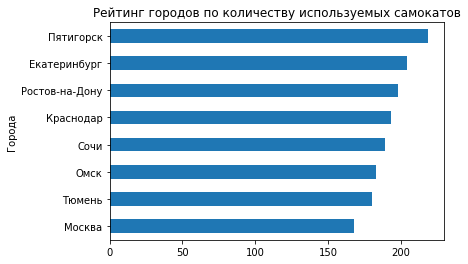

In [15]:
users_by_city = users['city'].value_counts(ascending = True).plot.barh()
plt.ylabel('Города')
plt.title('Рейтинг городов по количеству используемых самокатов')
plt.show()

***Соотношение пользователей с подпиской и без подписки***

In [16]:
users['subscription_type'].value_counts()

free     835
ultra    699
Name: subscription_type, dtype: int64

С подпиской пользователей меньше на 136.

***Представим визуализацию в процентном соотношении***

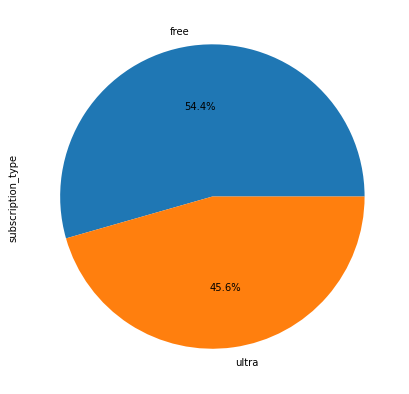

In [17]:
users.groupby(by='subscription_type')['subscription_type'].count().plot(kind='pie',
figsize=(10,7),
autopct = '%1.1f%%')
plt.show()

С подпиской 699 (45,6%) пользователей, без подписки 835 (54,4%). С подпиской пользователей меньше на 136 (8,8%).

***Возраст пользователей***

Посмотрим соотношение возраста пользователей.

In [18]:
display(users['age'].describe())

count   1,534.00
mean       24.90
std         4.57
min        12.00
25%        22.00
50%        25.00
75%        28.00
max        43.00
Name: age, dtype: float64

***Визуализируем информацию***

Ниже, я решил продублировать информацию в гистограммах на визуализациях в violinplot, так как этот график отображает распределение, медиану и межквартильный диапазон данных.

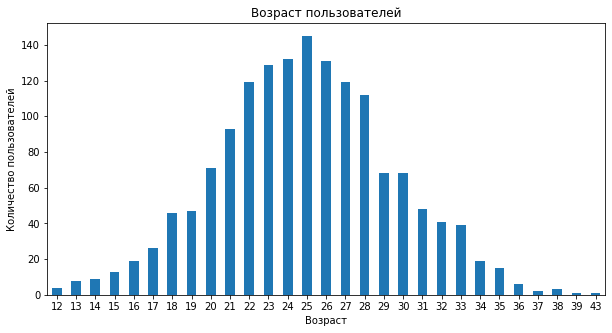

In [19]:
users.groupby('age')['age'].count().plot.bar(figsize = (10,5))
plt.xticks(rotation = 0)
plt.ylabel('Количество пользователей')
plt.xlabel('Возраст')
plt.title('Возраст пользователей')
plt.show()

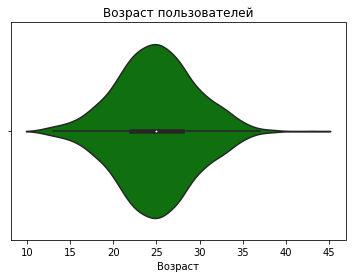

In [20]:
sns.violinplot(users['age'], color='green')
plt.title('Возраст пользователей')
plt.xlabel('Возраст');

Больше всего пользуются сервисом люди примерно от 23 до 26 лет. Пользователи от 30 лет пользуются сервисом меньше и далее тенденция идет на спад.

***Расстояние, которое пользователь преодолел за одну поездку***

In [21]:
display(riders['distance'].describe())

count   18,068.00
mean     3,070.66
std      1,116.83
min          0.86
25%      2,543.23
50%      3,133.61
75%      3,776.22
max      7,211.01
Name: distance, dtype: float64

Самое минимальное расстояния, которое пользователь преодолел за одну поездку - 0.86 м.

Самое максимальное расстояние - 7.211 м.

***Визуализируем***

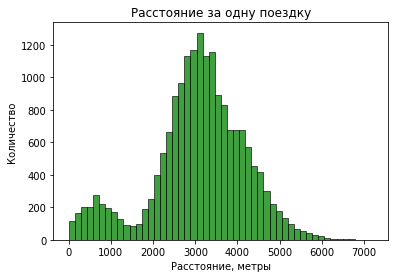

In [22]:
sns.histplot(data=riders, x='distance', color='green', bins=50)
plt.ylabel('Количество')
plt.xlabel('Расстояние, метры')
plt.title('Расстояние за одну поездку')
plt.show()

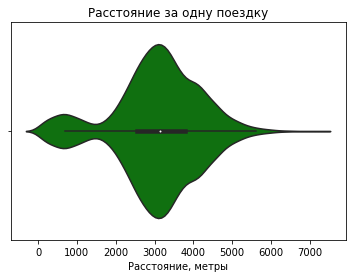

In [23]:
sns.violinplot(riders['distance'], color='green')
plt.title('Расстояние за одну поездку')
plt.xlabel('Расстояние, метры');

В среднем, пользователи преодолевают расстояние от 2,5 до 4 км.
Самое частое расстояние, которое проезжают пользователи в районе 3,1 км (3100м).

***Общее время поездок для каждого пользователя***

In [24]:
display(riders['duration'].describe())

count   18,068.00
mean        17.81
std          6.09
min          0.50
25%         13.60
50%         17.68
75%         21.72
max         40.82
Name: duration, dtype: float64

***Визуализируем***

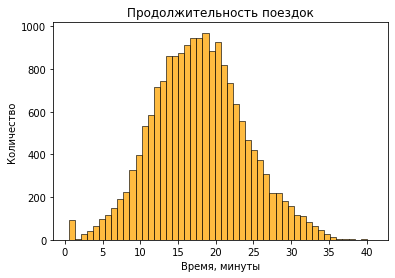

In [25]:
sns.histplot(data=riders, x='duration', color='orange', bins=50)
plt.ylabel('Количество')
plt.xlabel('Время, минуты')
plt.title('Продолжительность поездок')
plt.show()

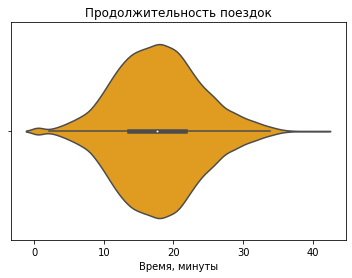

In [26]:
sns.violinplot(riders['duration'], color='orange')
plt.title('Продолжительность поездок')
plt.xlabel('Время, минуты');

Продолжительность поездки в среднем занимает от 14 до 22 минут.

***Вывод***

**Частота встречаемости городов**

В лидерах по количеству пользователей идет Пятигорск (219). Следом идут Екатеринбург (204), Ростов-на-Дону (198) и Краснодар (193). Замыкает рейтинг Москва (168). Возможно, это связано с тем, что Пятигорск меньше Москвы.

**Соотношение пользователей с подпиской и без подписки**

Используют бесплатную подписку 835 человек - это 54,4%. Платную подписку используют 699 - это 45,6%.

**Возраст пользователей**

Больше всего пользуются сервисом люди примерно от 23 до 26 лет. Пользователи от 30 лет пользуются сервисом меньше и далее тенденция идет на спад.

В среднем, больше всего пользователей в районе 25 лет.


**Расстояние, которое пользователь преодолел за одну поездку**

Самое минимальное расстояния, которое пользователь преодолел за одну поездку - 0.86 м.

Самое максимальное расстояние - 7.211 м.


**Продолжительность поездок**

Продолжительность поездки в среднем занимает от 14 до 22 минут.

Самая короткая меньше минуты. Тут возможны факторы неисправности самокатов, либо у пользователей изменились планы.
Самая длинная поездка была около 41 минуты. Возможно, пользователь брал самокат на 1 день для того, чтобы решить дела по городу, либо для поездкам по паркам или зонам отдыха.

#### Шаг 4. Объединение данных

***Объединим данные с пользователями, поездками и подписками в один датафрейм***

In [27]:
full_data = pd.merge(users, riders, on='user_id', how='inner')

In [28]:
full_data = pd.merge(full_data, subs, on='subscription_type', how='inner')

***Проверим даитафрейм***

In [29]:
full_data

,user_id,name,age,city,subscription_type,distance,duration,date,month,year,minute_price,start_ride_price,subscription_fee
0,1,Кира,22,Тюмень,ultra,"4,409.92",25.60,2021-01-01,2021-01,2021,6,0,199
1,1,Кира,22,Тюмень,ultra,"2,617.59",15.82,2021-01-18,2021-01,2021,6,0,199
2,1,Кира,22,Тюмень,ultra,754.16,6.23,2021-04-20,2021-04,2021,6,0,199
3,1,Кира,22,Тюмень,ultra,"2,694.78",18.51,2021-08-11,2021-08,2021,6,0,199
4,1,Кира,22,Тюмень,ultra,"4,028.69",26.27,2021-08-28,2021-08,2021,6,0,199
...,...,...,...,...,...,...,...,...,...,...,...,...,...
18063,1534,Альберт,25,Краснодар,free,"3,781.10",19.82,2021-11-04,2021-11,2021,8,50,0
18064,1534,Альберт,25,Краснодар,free,"2,840.42",21.41,2021-11-16,2021-11,2021,8,50,0
18065,1534,Альберт,25,Краснодар,free,"3,826.19",18.44,2021-11-18,2021-11,2021,8,50,0
18066,1534,Альберт,25,Краснодар,free,"2,902.31",16.67,2021-11-27,2021-11,2021,8,50,0


In [30]:
full_data.shape

(18068, 13)

У получившегося датафрейма 18068 строк, что до этого соответствует такому же количеству строк в датафрейме riders.

***Создадим датафрейм с данными о пользователях без подписки***

In [31]:
free_subs = full_data.query("`subscription_type` == 'free'")

***Проверим датафрейм***

In [32]:
free_subs

,user_id,name,age,city,subscription_type,distance,duration,date,month,year,minute_price,start_ride_price,subscription_fee
6500,700,Айдар,22,Омск,free,"2,515.69",14.94,2021-01-02,2021-01,2021,8,50,0
6501,700,Айдар,22,Омск,free,846.93,16.23,2021-02-01,2021-02,2021,8,50,0
6502,700,Айдар,22,Омск,free,"4,004.43",20.02,2021-02-04,2021-02,2021,8,50,0
6503,700,Айдар,22,Омск,free,"1,205.91",9.78,2021-02-10,2021-02,2021,8,50,0
6504,700,Айдар,22,Омск,free,"3,047.38",17.43,2021-02-14,2021-02,2021,8,50,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
18063,1534,Альберт,25,Краснодар,free,"3,781.10",19.82,2021-11-04,2021-11,2021,8,50,0
18064,1534,Альберт,25,Краснодар,free,"2,840.42",21.41,2021-11-16,2021-11,2021,8,50,0
18065,1534,Альберт,25,Краснодар,free,"3,826.19",18.44,2021-11-18,2021-11,2021,8,50,0
18066,1534,Альберт,25,Краснодар,free,"2,902.31",16.67,2021-11-27,2021-11,2021,8,50,0


***Визуализируем информацию по расстоянию без подписки***

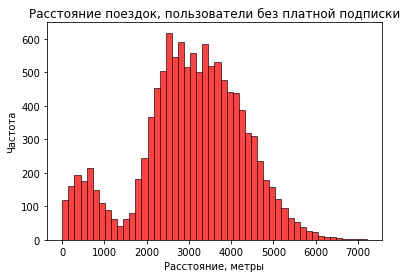

In [33]:
sns.histplot(data=free_subs, x='distance', color='red', bins=50)
plt.ylabel('Частота')
plt.xlabel('Расстояние, метры')
plt.title('Расстояние поездок, пользователи без платной подписки')
plt.show()

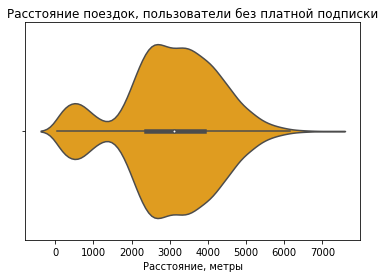

In [34]:
sns.violinplot(free_subs['distance'], color='orange')
plt.title('Расстояние поездок, пользователи без платной подписки')
plt.xlabel('Расстояние, метры');

Пользователи без платной подписки проезжают от 2,2 до 4 км. Чаще всего проезжают расстояния в 2,5км.

***Визуализируем информацию по времени без подписки***

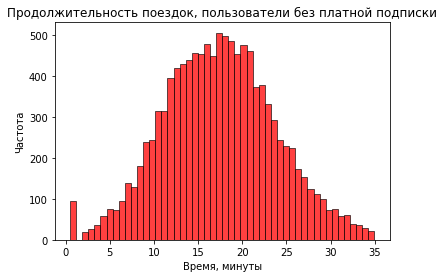

In [35]:
sns.histplot(data=free_subs, x='duration', color='red', bins=50)
plt.ylabel('Частота')
plt.xlabel('Время, минуты')
plt.title('Продолжительность поездок, пользователи без платной подписки')
plt.show()

Наблюдаются выбросы размером менее 100 поездок с продолжительностью до 1 минуты.

In [36]:
riders.query('duration == 0.5')['distance'].describe()

count      95.00
mean    5,113.18
std       658.25
min     4,030.31
25%     4,611.51
50%     5,052.77
75%     5,488.46
max     7,211.01
Name: distance, dtype: float64

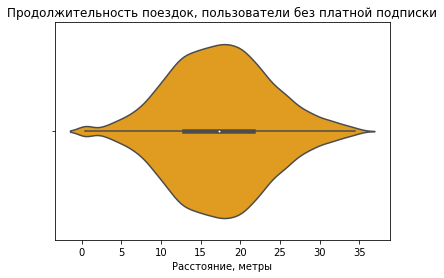

In [37]:
sns.violinplot(free_subs['duration'], color='orange')
plt.title('Продолжительность поездок, пользователи без платной подписки')
plt.xlabel('Расстояние, метры');

Время в пиковых значениях поездок составляет от 13 до 23 минут. Больше всего поездок около 18 минут.

***Создадим датафрейм с данными о пользователях с подпиской***

In [38]:
ultra_subs = full_data.query("`subscription_type` == 'ultra'")

***Проверим датафрейм***

In [39]:
ultra_subs

,user_id,name,age,city,subscription_type,distance,duration,date,month,year,minute_price,start_ride_price,subscription_fee
0,1,Кира,22,Тюмень,ultra,"4,409.92",25.60,2021-01-01,2021-01,2021,6,0,199
1,1,Кира,22,Тюмень,ultra,"2,617.59",15.82,2021-01-18,2021-01,2021,6,0,199
2,1,Кира,22,Тюмень,ultra,754.16,6.23,2021-04-20,2021-04,2021,6,0,199
3,1,Кира,22,Тюмень,ultra,"2,694.78",18.51,2021-08-11,2021-08,2021,6,0,199
4,1,Кира,22,Тюмень,ultra,"4,028.69",26.27,2021-08-28,2021-08,2021,6,0,199
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6495,699,Оксана,22,Москва,ultra,"3,973.05",24.67,2021-08-29,2021-08,2021,6,0,199
6496,699,Оксана,22,Москва,ultra,"3,288.70",15.89,2021-09-12,2021-09,2021,6,0,199
6497,699,Оксана,22,Москва,ultra,"3,076.16",14.39,2021-09-26,2021-09,2021,6,0,199
6498,699,Оксана,22,Москва,ultra,"4,707.85",15.84,2021-10-17,2021-10,2021,6,0,199


***Визуализируем информацию по расстоянию с подпиской***

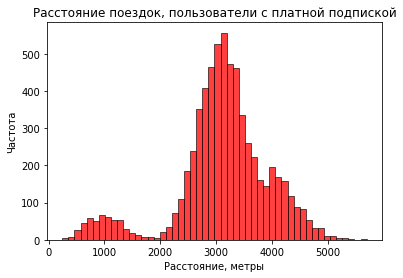

In [40]:
sns.histplot(data=ultra_subs, x='distance', color='red', bins=50)
plt.ylabel('Частота')
plt.xlabel('Расстояние, метры')
plt.title('Расстояние поездок, пользователи с платной подпиской')
plt.show()

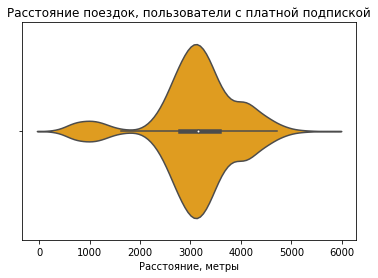

In [41]:
sns.violinplot(ultra_subs['distance'], color='orange')
plt.title('Расстояние поездок, пользователи с платной подпиской')
plt.xlabel('Расстояние, метры');

Пользователи с платной подпиской проезжают от 2,8 до 3,8км. Пик расстояния приходится на 3,2км.

***Визуализируем информацию по времени с подпиской***

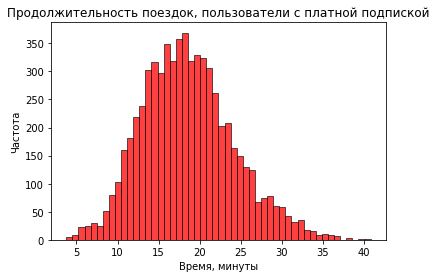

In [42]:
sns.histplot(data=ultra_subs, x='duration', color='red', bins=50)
plt.ylabel('Частота')
plt.xlabel('Время, минуты')
plt.title('Продолжительность поездок, пользователи с платной подпиской')
plt.show()

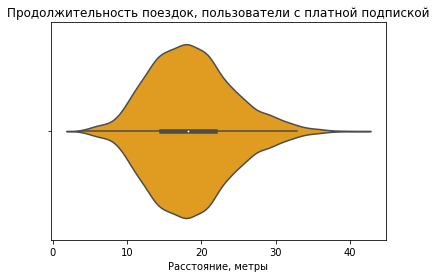

In [43]:
sns.violinplot(ultra_subs['duration'], color='orange')
plt.title('Продолжительность поездок, пользователи с платной подпиской')
plt.xlabel('Расстояние, метры');

Время пиковых значений поездок составляет от 14 до 22 минут.

**Вывод**

Были объединены данные о пользователях, поездках и тарифах в один датафрейм.

Вывели на основе одного датафрейме еще пару:

* free_subs - данные о пользователях без подписки;
* ultra_subs - данные о пользователях с подпиской.

Также, были построены визуализации для каждого из тарифов по времени и расстоянию.

У бесплатного тарифа интервал времени на пиковых значениях поездок составляет от 13 до 23 минут. Больше всего поездок около 18 минут. Также, пользователи проезжают от 2,2 до 4 км. Чаще всего проезжают расстояния в 2,5км. Есть такие, кто проежает 6км и более.

Если смотреть информацию по платному тарифу, то время пиковых значений поездок составляет от 15 до 23 минут. Расстояние от 2,8 до 3,8км. Чаще всего проезжают расстояния 3,2км.

Если делать вывод на этой основе то, пользователи на обоих тарифах проезжают приблизительно одинковые расстояния и используют одинаковое время.

#### Шаг 5. Подсчёт выручки

***Найдем суммарное расстояние, количество поeздок и суммарное время для каждого пользователя за каждый месяц***

***Округляем данные перед рассчетом***

In [44]:
full_data['duration'] = np.ceil(full_data['duration'])

***Создаем датафрейм c агрегированными данными***

In [45]:
total_df = full_data.pivot_table(
    index=['user_id', 'month'], 
    values = ['distance', 'duration', 'name', 'subscription_type'], 
    aggfunc={'distance':'sum', 'duration':'sum', 'name':'count', 'subscription_type': 'min'})
total_df.head(15)

distance  duration  name subscription_type
user_id month                                              
1       2021-01  7,027.51     42.00     2             ultra
        2021-04    754.16      7.00     1             ultra
        2021-08  6,723.47     46.00     2             ultra
        2021-10  5,809.91     32.00     2             ultra
        2021-11  7,003.50     56.00     3             ultra
        2021-12  6,751.63     28.00     2             ultra
2       2021-03 10,187.72     63.00     3             ultra
        2021-04  6,164.38     40.00     2             ultra
        2021-06  3,255.34     14.00     1             ultra
        2021-07  6,780.72     48.00     2             ultra
        2021-08    923.01      7.00     1             ultra
        2021-10  2,824.64     19.00     1             ultra
        2021-12  3,828.25     12.00     1             ultra
3       2021-01  3,061.78     13.00     1             ultra
        2021-02  5,421.15     39.00     2             ultra

In [46]:
#переименуем столбец name
total_df.rename(columns = {'name' : 'trip_cnt'}, inplace = True)

***Помесячная выручка на тарифе *ultra* и *free****

In [50]:
total_df = pd.pivot_table(full_data, index=['user_id', 'month'], 
                            values = ['distance', 'name', 
                                      'duration', 'subscription_type', 'start_ride_price', 'subscription_fee', 'minute_price'], 
                            aggfunc={'distance': 'sum', 
                                     'name': 'count',
                                     'duration': 'sum',
                                     'subscription_type': 'first',
                                     'start_ride_price': 'first',
                                     'subscription_fee': 'first',
                                     'minute_price': 'first'}).reset_index()

In [51]:
total_df['revenue'] = ((total_df['name']*total_df['start_ride_price']) + (total_df['duration']*total_df['minute_price']) + total_df['subscription_fee'])

In [52]:
#Посмотрим данные которые получились
total_df

,user_id,month,distance,duration,minute_price,name,start_ride_price,subscription_fee,subscription_type,revenue
0,1,2021-01,"7,027.51",42.00,6,2,0,199,ultra,451.00
1,1,2021-04,754.16,7.00,6,1,0,199,ultra,241.00
2,1,2021-08,"6,723.47",46.00,6,2,0,199,ultra,475.00
3,1,2021-10,"5,809.91",32.00,6,2,0,199,ultra,391.00
4,1,2021-11,"7,003.50",56.00,6,3,0,199,ultra,535.00
...,...,...,...,...,...,...,...,...,...,...
11326,1534,2021-06,"3,409.47",26.00,8,2,50,0,free,308.00
11327,1534,2021-08,"7,622.45",48.00,8,2,50,0,free,484.00
11328,1534,2021-09,"4,928.17",23.00,8,1,50,0,free,234.00
11329,1534,2021-11,"13,350.02",78.00,8,4,50,0,free,824.00


***Посмотрим на то, сколько пользователи тратят в серднем в месяц на платной подписке***

In [53]:
total_df.loc[total_df['subscription_type'] == 'ultra']['revenue'].describe()

count   4,533.00
mean      362.79
std        88.26
min       223.00
25%       301.00
50%       337.00
75%       409.00
max       955.00
Name: revenue, dtype: float64

***Посмотрим на то, сколько пользователи тратят в серднем в месяц на бесплатной подписке***

In [54]:
total_df.loc[total_df['subscription_type'] == 'free']['revenue'].describe()

count   6,798.00
mean      328.64
std       183.87
min        58.00
25%       194.00
50%       274.00
75%       428.00
max     1,444.00
Name: revenue, dtype: float64

**Вывод**

Добавлен новый датафрейм с агрегированными данными *total_df*.

В нем есть данные о количестве поездок суммарном расстоянии и суммарное время для каждого пользователя помесячно. 

Был добавлен столбец выручкой для каждого пользователя за каждый месяц.

В среднем в месяц пользователи с подпиской тратят на аренду 362.79 руб. Пользователи без подписки 328.64 руб. Таким образом, в среднем, пользователи с подпиской приносят на 34.15 руб. больше, чем пользователи без платной подписки.

#### Шаг 6. Проверка гипотез

***6.1 Важно понять, тратят ли пользователи с подпиской больше времени на поездки?***

Если да, то пользователи с подпиской могут быть «выгоднее» для компании. Проверьте гипотезу. Используйте исходные данные о продолжительности каждой сессии — отдельно для подписчиков и тех, у кого нет подписки.

H0: Продолжительность поездок с подпиской равна продолжительности поездок без подписки.

H1: Продолжительность поездок с подпиской больше чем без подписки.

In [55]:
results = st.ttest_ind(ultra_subs['duration'], free_subs['duration'], alternative = 'greater')
alpha = 0.05
print(results.pvalue)
if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

1.2804098316645618e-34
Отвергаем нулевую гипотезу


In [56]:
print('Средняя продолжительности поездок по подписке:', round(ultra_subs['duration'].mean(),2), 'минут.')
print('Средняя продолжительности поездок без подписки:', round(free_subs['duration'].mean(),2), 'минут.')

Средняя продолжительности поездок по подписке: 18.54 минут.
Средняя продолжительности поездок без подписки: 17.39 минут.


**Вывод**: Была отвергнута нулевая гипотеза о том, что продолжительность поездок пользователей с подпиской равна продолжительности поездок пользователей без подписки. Соответственно, пользователи с подпиской тратят больше времени на аренду.

***6.2***

Расстояние одной поездки в 3130 метров — оптимальное с точки зрения износа самоката. Можно ли сказать, что среднее расстояние, которое проезжают пользователи с подпиской за одну поездку, не превышает 3130 метров? Проверьте гипотезу и сделайте выводы.

H0: Пользователи с подпиской проезжают среднее расстояние за одну поездку не больше 3130 метров.

H1: Пользователи с подпиской проезжают среднее расстояние за одну поездку более 3130 метров.

In [57]:
ultra_dist = ultra_subs['distance']

optimal_distant = 3130.0
alpha = 0.05

results = st.ttest_1samp(
    ultra_dist, 
    optimal_distant,
    alternative='greater')
    
print(results.pvalue)

if (results.pvalue < alpha):
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

0.9195368847849785
Не получилось отвергнуть нулевую гипотезу


**Вывод**: Не получилось отвергнуть нулевую гипотезу. Таким образом, можно говорить о том, что среднее расстояние за одну поездку, которое проезжают пользователи с подпиской не больше 3130 метров.

***6.3***

Проверьте гипотезу о том, будет ли помесячная выручка от пользователей с подпиской по месяцам выше, чем выручка от пользователей без подписки. Сделайте вывод.

H0:Cредняя выручка пользователей с подпиской равна cредней выручки пользователей без подписки.

H1:Cредняя выручка пользователей с подпиской больше чем средняя выручка пользователей без подписки.

In [58]:
results = st.ttest_ind(total_df.loc[total_df['subscription_type'] == 'ultra']['revenue'], 
                       total_df.loc[total_df['subscription_type'] == 'free']['revenue'], 
                       alternative = 'greater')

alpha = 0.05
print(results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

1.8850394384715216e-31
Отвергаем нулевую гипотезу


**Вывод**: Была отвергнута нулевая гипотеза. Таким образом, можно говорить о том, что выручка от пользователей с подпиской больше, чем выручка от пользователей без подписки.

***6.4***

Представьте такую ситуацию: техническая команда сервиса обновила сервера, с которыми взаимодействует мобильное приложение. Она надеется, что из-за этого количество обращений в техподдержку значимо снизилось. Некоторый файл содержит для каждого пользователя данные о количестве обращений до обновления и после него. Какой тест вам понадобился бы для проверки этой гипотезы?

**Ответ**: Будем использовать гипотезу о равенстве средних для зависимых выборок. Решать будем через метод scipy.stats.ttest_rel()

#### Шаг 7. Общий вывод

Было загружено 3 датафрейма: пользователи, поездки и подписки.

Привели тип данных у столбца date из датафрейма riders к нужному типу. Также, добавили столбец с номером месяца. Были удалены дубликаты строк из датафрейма с пользователями.

Был проведен исследовательский анализ данных:

Лидер по количеству пользователей Пятигорск - 219, а замыкает рейтинг Москва - 168 пользователей.
835 человек используют бесплатную подписку, это является 54,4% от общего числа пользователей. 699 человек используют бесплатную подписку, это 45,6% от общего числа пользователей.
Если говорить о возрасте пользователей, от это люди от 23 до 26 лет. Пользователи от 30 лет пользуются сервисом меньше и далее тенденция идет на спад. В среднем, больше всего пользователей в районе 25 лет.

Самое минимальное расстояния, которое пользователь преодолел за одну поездку - 0.86 м. Самое максимальное расстояние - 7.211 м.

Был создан общий датафрейм для пользователей с планой и бесплатной подпиской. На его основе были созданы еще два датафрейма:
Первый для пользователей только с платной подпиской, воторой для пользователей только с беспланой подпиской и визуализировали полученную информацию.

Вывели на основе одного датафрейма еще пару:

free_subs - данные о пользователях без подписки;
ultra_subs - данные о пользователях с подпиской.

Также, были построены визуализации для каждого из тарифов по времени и расстоянию.

У бесплатного тарифа интервал времени на пиковых значениях поездок составляет от 13 до 23 минут. Больше всего поездок около 18 минут. Также, пользователи проезжают от 2,2 до 4 км. Чаще всего проезжают расстояния в 2,5км. Есть такие, кто проежает 6км и более. 

Если смотреть информацию по платному тарифу, то время пиковых значений поездок составляет от 15 до 23 минут. Расстояние от 2,8 до 3,8км. Чаще всего проезжают расстояния 3,2км.

Если делать вывод на этой основе то, пользователи на обоих тарифах проезжают приблизительно одинковые расстояния и используют одинаковое время.

В среднем в месяц пользователи с подпиской тратят на аренду 362.79 руб. Пользователи без подписки 328.64 руб. Таким образом, в среднем, пользователи с подпиской приносят на 34.15 руб. больше, чем пользователи без платной подписки.

Исходя из данных можно сказать, что число пользователей с подпиской и без не сильно отличаются. Но пользователи с подпиской приносят прибыли больше и пользуются самокатами чуть чаще.

Были проверены следующие гипотезы:

H0: Продолжительность поездок с подпиской равна продолжительности поездок без подписки.

H1: Продолжительность поездок с подпиской больше чем без подписки.

Отвергли нулевую гипотезу. Соответственно, пользователи с подпиской тратят больше времени на аренду.

H0: Пользователи с подпиской проезжают среднее расстояние за одну поездку не больше 3130 метров.

H1: Пользователи с подпиской проезжают среднее расстояние за одну поездку более 3130 метров.

Не получилось отвергнуть нулевую гипотезу. Таким образом, можно говорить о том, что среднее расстояние за одну поездку, которое проезжают пользователи с подпиской не больше 3130 метров.

H0:Cредняя выручка пользователей с подпиской равна cредней выручки пользователей без подписки.

H1:Cредняя выручка пользователей с подпиской больше чем средняя выручка пользователей без подписки.

Отвергли нулевую гипотезу. Таким образом, можно говорить о том, что выручка от пользователей с подпиской больше, чем выручка от пользователей без подписки.

#### Шаг 7. Распределения

 **Задача 1**

Требуется выполнить план по продлению подписки 100 клиентами путем рассылки промокодов. Ранее вероятность продления была 10%. Требуется обеспечить выполнение плана с вероятностью неуспеха не более 5%. Построить график и ответить на вопрос. Сколько нужно разослать промокодов?

In [59]:
p = 0.1
promo_minimum = 1
clients = 100
mu=promo_minimum*p
sigma=sqrt(promo_minimum*p*(1-p))
distr=st.norm(mu, sigma)
while distr.cdf(clients) > 0.05:
    promo_minimum +=1
    mu=promo_minimum*p
    sigma=sqrt(promo_minimum*p*(1-p))
    distr=st.norm(mu, sigma)
print(f'Минимальное количество промокодов для рассылки: {promo_minimum}')

Минимальное количество промокодов для рассылки: 1169


Получается, что нужно разослать как минимум 1169 промокодов.

**Задача 2**

Планируется разослать клиентам 1 млн. уведомлений, которые клиенты открывают с вероятностью 40%. Требуется с помощью аппроксимации построить график распределения и оценить вероятность того, что не более 399.5 тыс. клиентов откроют уведомления.

In [61]:
p = 0.4  
n = 1000000
notification = 399500
mu = n*p
sigma = sqrt(n*p*(1-p))
distr = st.norm(mu, sigma)
result = distr.cdf(notification)
print(f'Вероятность, что не более 399.5 тыс. клиентов откроют уведомления равна {result:.2%}')

Вероятность, что не более 399.5 тыс. клиентов откроют уведомления равна 15.37%


Получается, что не более 399.5 тыс. клиентов откроют уведомления с вероятностью, которая равна 15.37%.

**Вывод**

Минимальное количество промокодов, которе нужно разослать для продления подписки - 1169. Это нужно, чтобы обеспечить выполнение плана за месяц с вероятностью неуспеха не более 5% для 100 пользователей.

Вероятность, что не более 399.5 тыс. клиентов откроют уведомления равна 15.37%. если разослать их 1 млн., при условии, что  уведомления, которые открывают клиенты равна вероятности в 40%.